In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"
os.environ["JAX_PLATFORMS"] = "cpu"

import numpy as np
import pandas as pd
import keras
import keras.ops as ops
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
#Figure settings to avoid super large plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 90

# Session 6: Customizing Keras

So far we have explored two different perspectives to neural network development:
 1. **Pure Keras**: High level of abstraction, intuitive and simple to use:
     - Declarative definitions using `models`, `layers`, `optimizers`, `losses`, `metrics`.
     - Standard pipeline: model creation ➔ `compile()` ➔ `fit()` ➔ `evaluate()`.
 2. **Pure JAX**: Low level of abstraction, flexible and fully customizable:
     - Array-oriented, functional programming paradigm.
     - Focused on automatic differentiation, JIT compilation, and vectorization.

However, in general, **none of these approaches** is ideal for a realistic, practical scenario.
 - The Keras API may not cover some specific details of our use case.
 - Programming everything in pure JAX would be tedious, very time-consuming and prone to errors.

Fortunately, Keras has been designed with the core principle of **progressive disclosure of complexity**:
 - You should always be able to get into lower-level workflows in a **gradual** way.
 - While you can gain control over small details, you should **retain most of the high-level convenience**.

## 1. Main Customization Strategy: Subclassing

The object-oriented nature of Keras allows for a pretty straightforward strategy of code reuse and customization: **Subclassing**.

 - All main entities (`Model`, `Layer`, `Loss`, `Metric`, `Optimizer`) are defined as Classes that are specialized via subclassing.
 - You may create your own models, layers, etc. by subclassing the base class, or any of the provided specializations (e.g., you may subclass the [`LSTM`](https://keras.io/api/layers/recurrent_layers/lstm/) layer to specialize the behavior of an LSTM).

### 1.1. Defining new Layers:

 - A `Layer` is the combination of a state (weights) + computations.
 - It receives some inputs, and generates some outputs exclusively based on the inputs and the weights.
 - Weights can be trainable or non-trainable. Trainable weights are updated by the optimizer on each training step.

__Example:__

In [2]:
class Linear(keras.layers.Layer):
    def __init__(self, units=32, input_dim=32):
        super().__init__()
        self.w = self.add_weight(
            shape=(input_dim, units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(shape=(units,), initializer="zeros", trainable=True)

    def call(self, inputs):
        return ops.matmul(inputs, self.w) + self.b

x = ops.ones((2, 2))
linear_layer = Linear(4, 2)
y = linear_layer(x)
print(y)

[[-0.11107881  0.04397596  0.08965507  0.00915349]
 [-0.11107881  0.04397596  0.08965507  0.00915349]]


#### 👉 Recommendation: Create weights **after** the input shape is known, using the `build()` method.

This method is automatically called by Keras the first time a Layer is executed.

In [3]:
class Linear(keras.layers.Layer):
    def __init__(self, units=32):
        super().__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return ops.matmul(inputs, self.w) + self.b

In [4]:
linear_layer = Linear(4)
y = linear_layer(x)
print(y)

[[ 0.06002665  0.00542292  0.01326862 -0.16811791]
 [ 0.06002665  0.00542292  0.01326862 -0.16811791]]


What are the differences between trainable weights, non-trainable weights and class attributes?
 - Weights (both trainable and non-trainable) have to be **arrays**.
 - Trainable weights will be **automatically optimized** during `fit`.
 - Non-trainable weights can be **manually updated** on every batch, during evaluation, etc.
 - Class attributes can be any object, buth they are **not tracked by Keras**. In general, they cannot be accessed during training/evaluation.

In general, the set of `Layers` provided by Keras are sufficient to define any NN architecture. However, they can be useful to define **domain-specific computations and constraints**.

In [5]:
import wfdb
#Local path to the MIT-BIH Arrhythmia
MITDB = '/opt/tljh/common/mitdb'
BEAT_CODES = set(['N','L','R','B','A','a','J','S','V','F','e','j','n','E','/','f','Q'])
LABEL_MAP = {'N':0,'L':0,'R':0,'B':0,
             'A':1,'a':1,'J':1,'S':1,'e':1,'j':1,'n':1,
             'V':2,'E':2,
             'F':3,
             '/':4,'f':4,'Q':4}
REC_LIST = [r.strip() for r in open(f'{MITDB}/RECORDS', 'r').readlines()]
REC_LIST = [r for r in REC_LIST if tuple(wfdb.rdrecord(f'{MITDB}/{r}').sig_name)==('MLII', 'V1')]
#Code from the last session to load and organize every beat in a global dataframe
def adjust_array_length(arr, peak):
    """Utility function to adjust the length of each array"""
    desired_length = 1501
    target_peak_index = 750
    current_length = len(arr)

    start_index = max(0, peak - target_peak_index)
    end_index = min(current_length, peak + (desired_length - target_peak_index))

    # Truncate the array around the peak
    truncated_array = arr[start_index:end_index, :]

    left_padding = target_peak_index - (peak - start_index)
    right_padding = desired_length - len(truncated_array) - left_padding

    # Extend the array if needed
    if left_padding > 0:
        left_pad_value = truncated_array[0, :]
        left_extension = np.full((left_padding, 2), left_pad_value)
    else:
        left_extension = np.empty(shape=(0, 2))

    if right_padding > 0:
        right_pad_value = truncated_array[-1, :]
        right_extension = np.full((right_padding, 2), right_pad_value)
    else:
        right_extension = np.empty(shape=(0, 2))

    # Combine the extensions and truncated array
    adjusted_array = np.concatenate((left_extension, truncated_array, right_extension))

    return adjusted_array
    
# Creation of a Pandas dataframe with homogeneized data for every beat
full_data = []
offset = 18 #Window cut with respect to previous and next peak.
for r in REC_LIST:
    rec = wfdb.rdrecord(f'{MITDB}/{r}')
    anns = wfdb.rdann(f'{MITDB}/{r}', 'atr')
    beat_mask = np.array([s in BEAT_CODES for s in anns.symbol])
    beat_indices = np.where(beat_mask)[0]
    beat_types = np.array(anns.symbol)[beat_indices]
    beat_locations = anns.sample[beat_indices]
    for i in range(1, len(beat_indices)-1):
        beat_data = {}
        beat_data['beat_sig'] = adjust_array_length(rec.p_signal[beat_locations[i-1]
                                                    + offset:beat_locations[i+1]-offset,:],
                                                    beat_locations[i]-beat_locations[i-1])
        beat_data['type'] = LABEL_MAP[beat_types[i]]
        beat_data['leads'] =  rec.sig_name
        beat_data['recname'] = rec.record_name
        full_data.append(beat_data)
df_beats = pd.DataFrame(full_data)
df_beats = df_beats.query('type!=4')
df_sample = df_beats.sample(n=10000, random_state=42)

📌 __Example__: Specialized Layer to calculate the heart rate around a specific heartbeat. It gets some beat windows, and for each of them returns the heart rate before the beat, after, and the ratio of both:

In [6]:
class HeartRateLayer(keras.Layer):
    def __init__(self, sampling_frequency):
        super().__init__()
        self.fs = float(sampling_frequency)

    def call(self, inputs):
        #We only require the first channel of each beat
        sig = inputs[:, :, 0]
        wlen = sig.shape[-1]
        def get_rate(beat_sig):
            """Calculates the rate for a single beat"""
            dsig = jnp.diff(beat_sig)
            ppeak = jnp.nonzero(dsig, size=1)[0]
            npeak = jnp.nonzero(dsig[::-1], size=1)[0]
            prate = (wlen//2-ppeak)/self.fs
            nrate = (wlen//2-npeak)/self.fs
            return jnp.array([prate, nrate, nrate/prate])

        return jax.vmap(get_rate)(sig)

(10000, 3, 1)


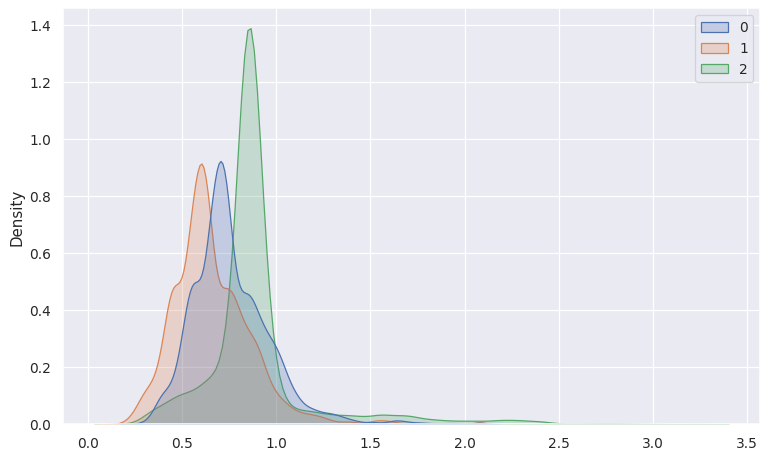

In [7]:
hr = HeartRateLayer(360.)
beats = np.stack(df_sample.beat_sig)
rates = hr(beats)
sns.kdeplot(rates.squeeze(), fill=True)
print(rates.shape)

This layer could for example be integrated in a convolutional architecture to provide explicitly these rhythm extra features to the final Dense layers.

### 1.2. Defining new Metrics and Losses

Following the same subclassing strategy, we may define our own `Metric` and `Loss` objects to be used for evaluating/guiding the optimization of a model.

#### 💡 Open discussion:

What are the key differences between metrics and losses?

<div style="height:10em"></div>

----

While metrics and losses are **conceptually similar** (they try to quantify the quality of a model with respect to some data), they have different objectives, properties and use cases:
 - Metrics **evaluate** the quality of a model in a specific problem.
     - They can be both stateless or stateful.
     - No continuity, differentiability or any smoothness properties are required.
     - Any problem may define specific quality metrics that do not make sense in other use cases or domains.
     - Developing a new metric can take a few hours.
 - Losses **guide** gradient-based optimization.
     - They are stateless functions.
     - They have to be differentiable and smooth.
     - Problem-specific losses are rare in practice.
     - Developing a new loss can take months of work.

#### 1.2.1. Metrics

If our metric is stateless (i.e., can be fully defined for each batch without depending on other batches), defining a new metric can be reduced to make a function with signature `metric_fn(y_true, y_pred)` that returns an **array of losses** (one for each sample in the input batch). Sample weighting is automatically applied by Keras.

__Example:__

```Python
def my_metric_fn(y_true, y_pred):
    squared_difference = ops.square(y_true - y_pred)
    return ops.mean(squared_difference, axis=-1)  # Note the `axis=-1`

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[my_metric_fn])
````

However, not all metrics can be expressed via stateless callables:
 - Metrics are evaluated **for each batch** during training and evaluation.
 - The average of the per-batch values is not always what you are interested in.

In those cases, you need to subclass `Metric`, and implement the following methods:
 1. State variables creation in `__init__`.
 2. Variables update in `update_state()`, that receives `y_true` and `y_pred` (equivalent to the stateless function above).
 3. Compute and reduce a single scalar metric in `result()`
 4. State clearing in `reset_states()`.

__Example:__

```Python
class BinaryTruePositives(keras.metrics.Metric):

  def __init__(self, name='binary_true_positives', **kwargs):
    super().__init__(name=name, **kwargs)
    self.true_positives = self.add_weight(name='tp', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    y_true = ops.cast(y_true, "bool")
    y_pred = ops.cast(y_pred, "bool")

    values = ops.logical_and(ops.equal(y_true, True), ops.equal(y_pred, True))
    if sample_weight is not None:
      values = values * sample_weight
    self.true_positives.assign_add(ops.sum(values))

  def result(self):
    return self.true_positives

  def reset_state(self):
    self.true_positives.assign(0)
```

#### 📋 Exercise 1

An interesting class of problems are those involving **ordinal classification**. In these problems, classes are not completely independent, but there is some kind of *distance* among them. Thus, classification errors may take into account this relation between classes when evaluating the model performance.

__Example dataset: [Wine quality estimation](https://archive.ics.uci.edu/dataset/186/wine+quality)__

This dataset aims at estimating the quality of a wine from a set of quantitative, objective features such as acidity, amount of alcohol, etc. The quality is labeled as an integer from 0 to 9.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
wine_data = pd.read_csv(url, sep=';')

# Features and target
X = wine_data.drop('quality', axis=1)
y = wine_data['quality']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Simple neural network model for classification
model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(10, activation='softmax')  # Output layer for classes 0 to 9
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,178 (12.41 KB)

 Trainable params: 3,178 (12.41 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=5, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

Epoch 1/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4241 - loss: 1.7246 - val_accuracy: 0.6953 - val_loss: 0.9511
Epoch 2/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - accuracy: 0.5833 - loss: 1.0343 - val_accuracy: 0.6797 - val_loss: 0.9186
Epoch 3/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - accuracy: 0.5715 - loss: 1.0585 - val_accuracy: 0.6797 - val_loss: 0.8648
Epoch 4/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - accuracy: 0.6032 - loss: 0.9702 - val_accuracy: 0.6719 - val_loss: 0.8529
Epoch 5/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - accuracy: 0.6353 - loss: 0.9215 - val_accuracy: 0.6680 - val_loss: 0.8570
Epoch 6/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - accuracy: 0.6227 - loss: 0.9044 - val_accuracy: 0.6797 - val_loss: 0.8480
Epoch 7/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - accuracy: 0.6274 - loss: 0.8927 - val_accuracy: 0.6094 - val_loss: 0.8952
Epoch 8/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - accuracy: 0.6254 - loss: 0.9044 - va

##### 📝 __Tasks__:
Using exclusively the `keras.ops` API:
 - Define a classification metric that ignores mistakes between score 4 and 5, and between 5 and 6. Then, any other error gets squared in their magnitude.
 - Compare this metric with the accuracy and also with a regression metric such as mean squared error and the loss evolution.
 - Try to reduce the overfitting by adding regularization (e.g. `Dropout`) after each hidden layer.

In [21]:
#Provide the code to solve Exercise 1:
def masked_ordinal_error(y_true, y_pred):
    #Convert from 10-class softmax output to class labels
    y_pred = ops.argmax(y_pred, axis=1)
    mask = (((y_true==4) & (y_pred==5)) | 
            ((y_true==5) & (y_pred==4)) | 
            ((y_true==5) & (y_pred==6)) | 
            ((y_true==6) & (y_pred==5)))
    y_pred_fixed = ops.where(mask, y_true, y_pred)
    return ops.square(y_true-y_pred_fixed)

model = keras.Sequential([
    keras.layers.Input(shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')  # Output layer for classes 0 to 9
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', 'mean_squared_error', masked_ordinal_error])

history = model.fit(X_train, y_train, epochs=30, batch_size=5, validation_split=0.2)
# Evaluate the model
evaluation = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {evaluation[1]:.2f}')

Epoch 1/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3882 - loss: 1.8301 - masked_ordinal_error: 2.6652 - mean_squared_error: 30.9500 - val_accuracy: 0.6289 - val_loss: 0.9699 - val_masked_ordinal_error: 0.4266 - val_mean_squared_error: 31.1062
Epoch 2/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.5397 - loss: 1.1828 - masked_ordinal_error: 0.5777 - mean_squared_error: 31.3333 - val_accuracy: 0.6875 - val_loss: 0.9093 - val_masked_ordinal_error: 0.5320 - val_mean_squared_error: 31.1108
Epoch 3/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.5753 - loss: 1.0813 - masked_ordinal_error: 0.5339 - mean_squared_error: 31.1338 - val_accuracy: 0.6836 - val_loss: 0.8797 - val_masked_ordinal_error: 0.4961 - val_mean_squared_error: 31.1110
Epoch 4/30
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - accuracy: 0.5797 - loss: 1.0594 - masked_ordinal_error: 0.6028 - mean_squared_error: 31.6186 - val_accuracy: 0.6641 - val_loss: 0.8643 - val_masked_ordinal_error: 0.6

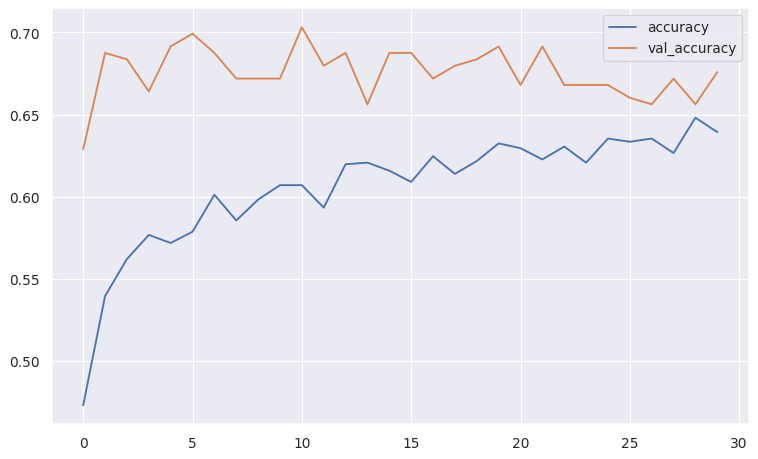

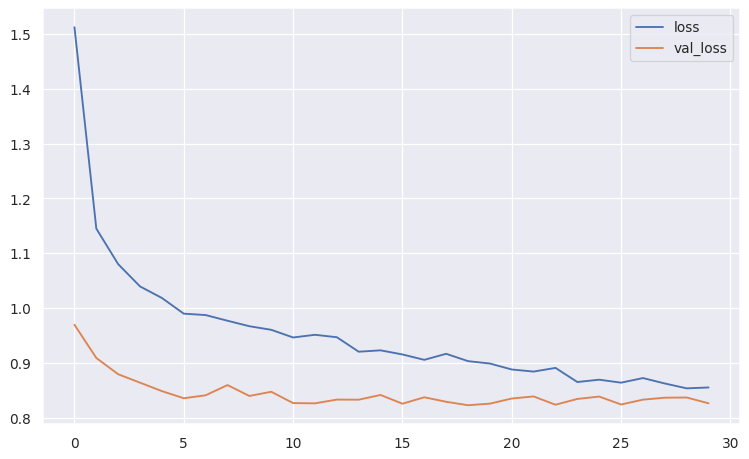

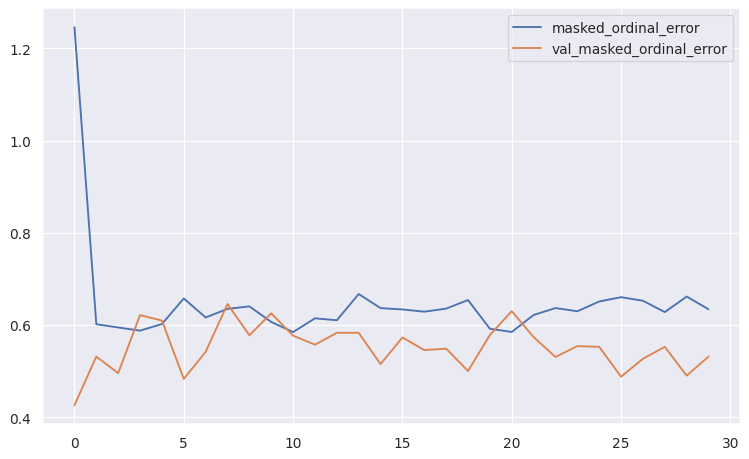

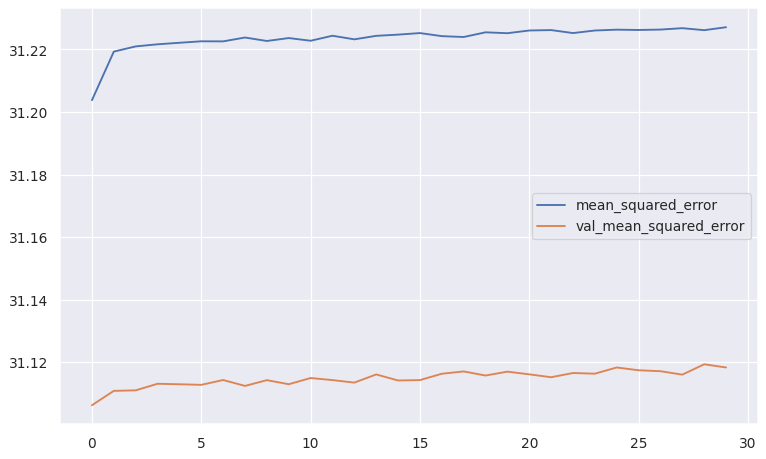

In [22]:
#Visualization of different metrics
for key in history.history:
    if key.startswith('val_'):
        continue
    plt.figure()
    plt.plot(history.history[key], label=key)
    plt.plot(history.history['val_'+key], label='val_'+key)
    plt.legend()

#### 1.1.2. Losses

In an analog way as we did for metrics, new losses may be defined either from a single function with the right interface, or by subclassing the base [`Loss`](https://keras.io/api/losses/#base-loss-api) class.

Interestingly, the function interface is **exactly the same** as the one for defining new metrics: `loss_fn(y_true, y_pred)` that returns an array of losses (one for each sample in the input batch). Sample weighting is automatically managed by Keras as well in this case.

__Example:__
```Python
def my_loss_fn(y_true, y_pred):
    squared_difference = ops.square(y_true - y_pred)
    return ops.mean(squared_difference, axis=-1)  # Note the `axis=-1`

model.compile(optimizer='adam', loss=my_loss_fn)
````

__⚠️ Even if the function interface is the same, a valid `Metric` may be catastrophic as a `Loss`.__

For the subclassing alternative, since losses are always stateless the implementation is more straightforward (no need to define/update/reset state variables). Just a proper initialization and the implementation of the `call` method is required:

```Python
keras.losses.Loss(name=None, reduction="sum_over_batch_size", dtype=None)
```

Arguments for initialization:
 - **reduction**: Type of reduction to apply to the loss. In almost all cases this should be `sum_over_batch_size`. Supported options are `sum`, `sum_over_batch_size`, `mean`, `mean_with_sample_weight` or `None`. `sum` sums the loss, `sum_over_batch_size` and `mean` sum the loss and divide by the sample size, and `mean_with_sample_weight` sums the loss and divides by the sum of the sample weights. `None` performs no aggregation. Defaults to `sum_over_batch_size`.
 - **name**: Optional name for the loss instance.

__Example:__
```Python
class MeanSquaredError(Loss):
    def call(self, y_true, y_pred):
        return ops.mean(ops.square(y_pred - y_true), axis=-1)
```


## 2. Customizing the training loop.

 - Sometimes it is not sufficient to define custom `Layers`, `Metrics` and `Losses`, but we need a more fine-grained control on how the model is trained.
 - Also, it can happen that the `Loss` interface can be a bit limited, as it only gives us access to `y_true` and `y_pred`.

For these use cases, it is necessary to subclass `Model` and reimplement some of the fundamental methods.
 - Still, rewriting [`fit()`](https://github.com/keras-team/keras/blob/dfaca0e1e8ffc14d68c81e07840049e9953db4ac/keras/src/backend/jax/trainer.py#L324) from scratch can be very **inconvenient**, as all batch partitioning, metrics updates, callback management, progress output, etc, should still be managed by Keras.

Thus, there are two main entry points for low-level customization of Keras models: `compute_loss_and_updates()` and `train_step()`. Each one has different responsibilities, illustrated in the next sections.

### 2.1. Rewriting `compute_loss_and_updates()`:

The input-output interface of this function in the JAX backend is as follows:
```Python
def compute_loss_and_updates(
        self, 
        trainable_vars, 
        non_trainable_vars, 
        metrics_vars,
        x, 
        y, 
        sample_weight, 
        training=False, 
        optimizer_variables=None
    ):
    
    ...
    
    return loss, (
            unscaled_loss,
            y_pred,
            non_trainable_variables,
            metrics_variables,
        )
```

The main advantage compared to defining custom losses as we explained in the previous section is that here **we have access to the model** and all trainable and non-trainable variables.
 - This allows us to define more complex loss models that take into account model properties. For example, the use of **model gradients in the loss** is frequent in physical modeling, such as [PINNs](https://en.wikipedia.org/wiki/Physics-informed_neural_networks).

📌 __Example:__

Let's build a neural network to approximate a vector-valued function $u$ in which the loss is defined from the following differential equation:

$$\frac{du}{dx} + u(x) = 0,\quad u(0)=1$$

In [23]:
INPUT_DIM = 3 # Sample input size
OUTPUT_DIM = 20 # Output size

#Data generation
x = np.random.normal(size=[10000, INPUT_DIM])

class CustomModel(keras.Model):
    
    def __init__(self, **kwargs):
        super().__init__()
        self.layer_list = [
            keras.layers.Dense(50, activation="tanh"),
            keras.layers.Dense(50, activation="tanh"),
            keras.layers.Dense(OUTPUT_DIM, activation="linear")
        ]

    def call(self, inputs):
        x = inputs
        for layer in self.layer_list:
            x = layer(x)
        return x

    def compute_loss_and_updates(self, trainable_vars, non_trainable_vars, metrics_vars, 
                                 x, y, sample_weight, training=False, 
                                 optimizer_variables=None):

        def u(x):
            """
            Convenient wrapper function to differentiate the model with respect
            to the inputs.
            """
            y_pred, _ = self.stateless_call(trainable_vars, non_trainable_vars, x)
            return y_pred

        #We calculate the jacobian for each input with jax.jvp
        ux, du_dx = jax.jvp(u, [x], [jnp.ones_like(x)])
        #Calculation of residual and final loss
        residual = du_dx + ux
        loss_residual = jnp.mean(jnp.square(residual))
        u_b = u(jnp.zeros_like(x))
        loss_boundary = jnp.mean(jnp.square(u_b-jnp.ones_like(u_b)))
        loss = loss_residual + loss_boundary
        return loss, (loss, u, non_trainable_vars, metrics_vars)

In [24]:
cmodel = CustomModel()
cmodel.compile(optimizer='adam')
cmodel(x)
display(cmodel.summary())
history = cmodel.fit(x, batch_size=100, epochs=150, validation_split=0.2)

Model: "custom_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_31 (Dense)                │ (10000, 50)            │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (10000, 50)            │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (10000, 20)            │         1,020 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,770 (14.73 KB)

 Trainable params: 3,770 (14.73 KB)

 Non-trainable params: 0 (0.00 B)

None

Epoch 1/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8143 - val_loss: 0.2123
Epoch 2/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 0.2029 - val_loss: 0.1746
Epoch 3/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step - loss: 0.1653 - val_loss: 0.1341
Epoch 4/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 0.1248 - val_loss: 0.0968
Epoch 5/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 0.0888 - val_loss: 0.0644
Epoch 6/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 0.0583 - val_loss: 0.0391
Epoch 7/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step - loss: 0.0368 - val_loss: 0.0257
Epoch 8/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - loss: 0.0259 - val_loss: 0.0209
Epoch 9/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - loss: 0.0232 - val_loss: 0.0174
Epoch 10/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 0.0193 - val_loss: 0.0154
Epoch 11/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 0.0174 - val_loss: 0.0139
Epoch 12/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 

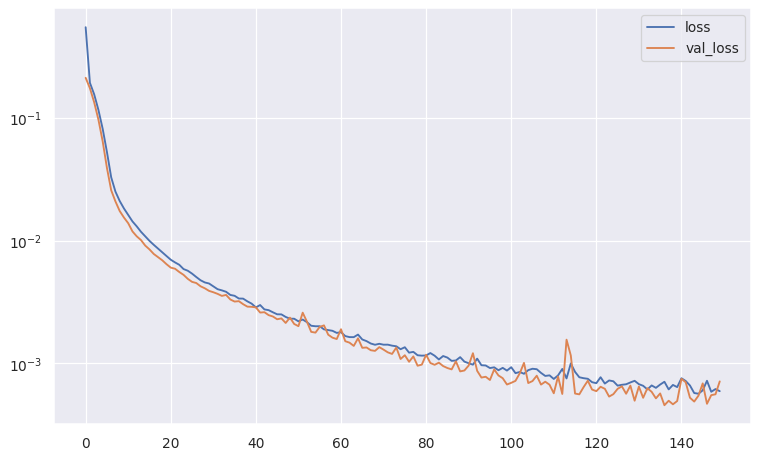

In [25]:
#Visualization of the learning curves
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.yscale('log')
plt.legend()

### 2.2. Rewriting `train_step()`:

Finally, if we really need to customize how model variables are optimized, `train_step()` is the method where the core learning process takes place. The input/output interface (in the JAX backend) is the following:

```Python
def train_step(self, state, data):
        (
            trainable_variables,
            non_trainable_variables,
            optimizer_variables,
            metrics_variables,
        ) = state

    ...

    return logs, state
```

To make this function fully stateless, the state comprising trainable, non-trainable, optimizer and metrics variables is specifically passed as a tuple. As output, we have to provide:
 - Another tuple with exactly the same components after updating.
 - The `logs` that will go in the `history` resulting from `fit()`.

If we take a look at the [default implementation of `train_step()`](https://github.com/keras-team/keras/blob/dfaca0e1e8ffc14d68c81e07840049e9953db4ac/keras/src/backend/jax/trainer.py#L110), we can see that the pipeline involves:
 1. Calculate the gradients of the loss function with respect to the trainable variables.
 2. Rely on the optimizer to apply the gradients and calculate the updated trainable and optimizer variables.
 3. Update the list of metrics, and get the logs and the updated metrics variables.
 4. Return the logs and all the updated variables.

Still, we don't need to reimplement every single step, because we will always have the option to call the default `train_step()` during our own implementation.


#### 📋 Exercise 2

Modify the behavior of the `CustomModel` class defined in the previous section, so that:
 - At the end of each training step, all the coefficients of the first dense layer sum exactly 1.

First, we can check that the coefficients of the first dense layer correspond exactly to the first trainable variable of the model:

In [26]:
cmodel.trainable_variables

[<KerasVariable shape=(3, 50), dtype=float32, path=custom_model/dense_31/kernel>,
 <KerasVariable shape=(50,), dtype=float32, path=custom_model/dense_31/bias>,
 <KerasVariable shape=(50, 50), dtype=float32, path=custom_model/dense_32/kernel>,
 <KerasVariable shape=(50,), dtype=float32, path=custom_model/dense_32/bias>,
 <KerasVariable shape=(50, 20), dtype=float32, path=custom_model/dense_33/kernel>,
 <KerasVariable shape=(20,), dtype=float32, path=custom_model/dense_33/bias>]

In [27]:
# Complete this code to solve Exercise 2:

class ConstrainedCustomModel(CustomModel):

    def train_step(self, state, data):
        #We apply standard training
        logs, state = super().train_step(state, data)
        #And now enforce the constraints on the first layer
        (
            trainable_variables,
            non_trainable_variables,
            optimizer_variables,
            metrics_variables,
        ) = state
        new_trainable_variables_0 = trainable_variables[0]/jnp.sum(trainable_variables[0])
        new_trainable_variables = [new_trainable_variables_0] + trainable_variables[1:]
        new_state = (new_trainable_variables, non_trainable_variables, optimizer_variables, metrics_variables)
        return logs, new_state

In [28]:
ccmodel = ConstrainedCustomModel()
ccmodel.compile(optimizer='adam')
history = ccmodel.fit(x, batch_size=100, epochs=150, validation_split=0.2)

Epoch 1/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8589 - val_loss: 0.2285
Epoch 2/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 0.2160 - val_loss: 0.1659
Epoch 3/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 0.1425 - val_loss: 0.1022
Epoch 4/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step - loss: 0.0904 - val_loss: 0.0631
Epoch 5/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 0.0604 - val_loss: 0.0417
Epoch 6/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - loss: 0.0410 - val_loss: 0.0324
Epoch 7/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 0.0315 - val_loss: 0.0282
Epoch 8/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - loss: 0.0295 - val_loss: 0.0240
Epoch 9/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 0.0276 - val_loss: 0.0215
Epoch 10/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 0.0234 - val_loss: 0.0188
Epoch 11/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - loss: 0.0213 - val_loss: 0.0161
Epoch 12/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [29]:
#We check if the constraint has been met
np.sum(ccmodel.trainable_variables[0].value)

Array(0.99999994, dtype=float32)

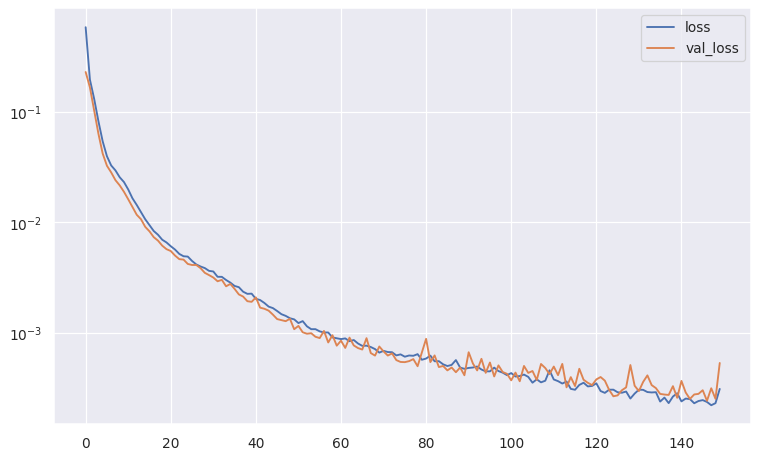

In [30]:
#Visualization of the learning curves
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.yscale('log')
plt.legend()

## 3. Callbacks

A callback is a powerful tool to customize the behavior of a Keras model during training, evaluation, or inference.

__Examples__:
 - `keras.callbacks.TensorBoard` to visualize training progress and results with TensorBoard.
 - `keras.callbacks.ModelCheckpoint` to periodically save your model during training.
 - `keras.callbacks.EarlyStopping` to stop training a model when a monitorid metric has stopped improving.

Callbacks may be used in the following methods, passing a list of `Callback` objects as the `callbacks=` argument:
 - `keras.Model.fit()`
 - `keras.Model.evaluate()`
 - `keras.Model.predict()`

### Overview of callback methods

#### Global methods

##### `on_(train|test|predict)_begin(self, logs=None)`

Called at the beginning of `fit`/`evaluate`/`predict`.

##### `on_(train|test|predict)_end(self, logs=None)`

Called at the end of `fit`/`evaluate`/`predict`.

#### Batch-level methods for training/testing/predicting

##### `on_(train|test|predict)_batch_begin(self, batch, logs=None)`

Called right before processing a batch during training/testing/predicting.

##### `on_(train|test|predict)_batch_end(self, batch, logs=None)`

Called at the end of training/testing/predicting a batch. Within this method, `logs` is
a dict containing the metrics results.

#### Epoch-level methods (training only)

##### `on_epoch_begin(self, epoch, logs=None)`

Called at the beginning of an epoch during training.

##### `on_epoch_end(self, epoch, logs=None)`

Called at the end of an epoch during training.

----

##### 📌 __Example:__ Basic implementation of Early Stopping:

In [31]:
class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

    Arguments:
        patience: Number of epochs to wait after min has been hit. After this
        number of no improvement, training stops.
    """

    def __init__(self, patience=0):
        super().__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("loss")
        if ops.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print(f"Epoch {self.stopped_epoch + 1}: early stopping")

Let's try it out with our constrained custom model:

In [32]:
ccmodel = ConstrainedCustomModel()
ccmodel.compile(optimizer='adam')
estop = EarlyStoppingAtMinLoss(patience=2)
history = ccmodel.fit(x, batch_size=100, epochs=150, 
                      validation_split=0.2, callbacks=[estop])

Epoch 1/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7982 - val_loss: 0.2217
Epoch 2/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 0.2191 - val_loss: 0.2057
Epoch 3/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 0.2011 - val_loss: 0.1863
Epoch 4/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step - loss: 0.1814 - val_loss: 0.1540
Epoch 5/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 0.1440 - val_loss: 0.1118
Epoch 6/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 0.1030 - val_loss: 0.0739
Epoch 7/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 0.0694 - val_loss: 0.0543
Epoch 8/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - loss: 0.0545 - val_loss: 0.0460
Epoch 9/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - loss: 0.0416 - val_loss: 0.0391
Epoch 10/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step - loss: 0.0412 - val_loss: 0.0333
Epoch 11/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 0.0330 - val_loss: 0.0304
Epoch 12/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 

### Recommendations when writing Callbacks

 1. Callbacks are not JIT-compiled. Thus, **avoid implementing any computing-intensive task in callbacks**, and do it in layers or in the appropriate method of `Model`.
 2. The main use cases of callbacks are related to **logging and general configuration/behavior update**. Examples:
    - Set `self.model.stop_training = True` to immediately interrupt training.
    - Mutate hyperparameters of the optimizer (available as `self.model.optimizer`), such as `self.model.optimizer.learning_rate`.
    - Save the model at period intervals.
    - Record the output of `model.predict()` on a few test samples at the end of each epoch, to use as a sanity check during training.
    - Extract visualizations of intermediate features at the end of each epoch, to monitor
what the model is learning over time.

#### 📋 Exercise 3

Based on `EarlyStoppingAtMinLoss`, define a new `Callback` that implements **early stopping with a twist**: instead of stopping training, it should reduce the learning rate if there's no improvement in validation loss for a certain number of epochs. After a minimun learning rate is reached, then it stops the training.

 - Test it with the same model, and compare the behavior with `EarlyStoppingAtMinLoss`.

__Hints:__
 - The current learning rate can be accessed from: `self.model.optimizer.learning_rate`
 - The learning rate can be updated as follows: `self.model.optimizer.learning_rate.assign(new_lr)`

In [33]:
# Complete the code to solve Exercise 3
class EarlyStoppingAdaptiveLR(EarlyStoppingAtMinLoss):
    def __init__(self, patience=3, reduction_factor=0.5, min_lr=1e-5):
        super().__init__(patience)
        self.reduction_factor = reduction_factor
        self.min_lr = min_lr

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get('val_loss')

        if ops.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1            
            if self.wait >= self.patience:
                old_lr = self.model.optimizer.learning_rate
                new_lr = ops.max([old_lr * self.reduction_factor, self.min_lr])
                #Early stopping condition
                if ops.equal(new_lr, self.min_lr):
                    self.stopped_epoch = epoch
                    self.model.stop_training = True
                    print("Restoring model weights from the end of the best epoch.")
                    self.model.set_weights(self.best_weights)
                else:
                    self.model.optimizer.learning_rate.assign(new_lr)
                    print(f"\nEpoch {epoch + 1}: reducing learning rate to {new_lr:.6f}.")
                    self.wait = 0     

In [34]:
ccmodel = ConstrainedCustomModel()
ccmodel.compile(optimizer='adam')
estop = EarlyStoppingAdaptiveLR(patience=2)
history = ccmodel.fit(x, batch_size=100, epochs=150, 
                      validation_split=0.2, callbacks=[estop])

Epoch 1/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1007 - val_loss: 0.2684
Epoch 2/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 619us/step - loss: 0.2083 - val_loss: 0.1685
Epoch 3/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 0.1832 - val_loss: 0.2286
Epoch 4/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 497us/step - loss: 0.2019 - val_loss: 0.1414
Epoch 5/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - loss: 0.1328 - val_loss: 0.1071
Epoch 6/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - loss: 0.1003 - val_loss: 0.0822
Epoch 7/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 0.0722 - val_loss: 0.0782
Epoch 8/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - loss: 0.0740 - val_loss: 0.0563
Epoch 9/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 0.0583 - val_loss: 0.0485
Epoch 10/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 0.0483 - val_loss: 0.0436
Epoch 11/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 0.0423 - val_loss: 0.0368
Epoch 12/150
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 

## References:

 - Keras - Making new layers & models via subclassing: https://keras.io/guides/making_new_layers_and_models_via_subclassing/
 - Keras Metrics: https://keras.io/api/metrics/
 - Keras Losses: https://keras.io/api/losses/
 - Keras - Custom train step in JAX: https://keras.io/guides/custom_train_step_in_jax/
 - Keras - Callbacks: https://keras.io/guides/writing_your_own_callbacks/